# Week 3 - Linear regression

In week 1, we introduced **univariate linear regression**. However, the problem was that the fitted model was linear, while the data was not.  

To increase the **expressiveness** of the model, we can apply **feature engineering**. For example, if we have a single feature $x_1$, we can create a feature vector:  

$$
[x_1, x_1^2, x_1^3]
$$

This transformation allows the function to be **nonlinear in input features** but still **linear in parameters**, a technique known as **polynomial regression**.  

Additionally, we will explore other regression methods to further improve our model’s performance.  

In [4]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd




The `OLS` class implements simple linear regression, similar to the algorithm we implemented in week 1. As before, we define the `fit`, `predict`, and `score` methods.  

However, this implementation is multivariate, meaning it can handle multiple-element feature vectors instead of just a single feature. This allows the model to learn relationships from multiple input variables, making it more flexible.



In [5]:

class OLS:
    def __init__(self):
        self.w = None
        self.x = None
        self.y = None
        pass
        
    def fit(self, x, y):
        self.x = x
        self.y = y
        self.w = OLS.ols(x=x, y=y)
        pass

    @staticmethod
    def ols(x, y):
        XX = x.T.dot(x)
        Xy = x.T.dot(y)
        w = np.linalg.solve(XX,Xy)
        # solving the linear equation system is equivalent to copmuting XXi.dot(Xy) as follows:
        # XXi = np.inv(XX)
        # w = XXi.dot(Xy)
        return w
    
    def pred(self, x):
        return x.dot(self.w)

    def mse(self, x=None, y=None):
        if x is None:
            x = self.x
        if y is None:
            y = self.y
        y_pred = self.pred(x)
        residuals = y - y_pred
        mse = np.mean(residuals*residuals)
        return mse

    def score(self, x=None, y=None):
        return -self.mse(x=x, y=y)


## PolynomialRegression  

The `PolynomialRegression` class performs feature extraction by transforming the input features into a polynomial of a specified order. This allows the model to capture more complex relationships in the data by extending the feature space.


In [6]:
class PolynomialRegression:

    @staticmethod
    def polynomial_design(x, degree=1):
        n = x.shape[0]
        X = np.ones((n,degree+1))
        for k in range(1,degree+1):
            X[:,k] = X[:,k-1] * x   
        return X

    def __init__(self, degree=1, linear_regression=None):
        if linear_regression is None:
            linear_regression=OLS()
        self.linear_regression = linear_regression
        self.degree = degree
        self.x = None
        
    def fit(self, x, y):
        self.x = x
        X = PolynomialRegression.polynomial_design(x,degree=self.degree)
        self.linear_regression.fit(x=X,y=y)

    def pred(self, x):
        X = PolynomialRegression.polynomial_design(x,degree=self.degree)
        return self.linear_regression.pred(x=X)

We will use the temperature data from the previous weeks to illustrate the use of the PolynomialRegression class.

In [7]:
def load_data(year = None):
    """
    load data from a weather station in Potsdam
    """
    names = ['station', 'date' , 'type', 'measurement', 'e1','e2', 'E', 'e3']
    data = pd.read_csv('../datasets/weatherstations/GM000003342.csv', names = names)
    # convert the date column to datetime format
    data['date'] = pd.to_datetime(data['date'], format="%Y%m%d") # 47876 unique days
    types = data['type'].unique()

    tmax = data[data['type']=='TMAX'][['date','measurement']] # Maximum temperature (tenths of degrees C), 47876
    tmin = data[data['type']=='TMIN'][['date','measurement']] # Minimum temperature (tenths of degrees C), 47876
    prcp = data[data['type']=='PRCP'][['date','measurement']] # Precipitation (tenths of mm), 47876
    snwd = data[data['type']=='SNWD'][['date','measurement']] # Snow depth (mm), different shape
    tavg = data[data['type']=='TAVG'][['date','measurement']] # average temperature, different shape 1386
    arr = np.array([tmax.measurement.values,tmin.measurement.values, prcp.measurement.values]).T 

    df = pd.DataFrame(arr/10.0, index=tmin.date, columns=['TMAX', 'TMIN', 'PRCP']) # compile data in a dataframe and convert temperatures to degrees C, precipitation to mm

    if year is not None:
        df = df[pd.to_datetime(f'{year}-1-1'):pd.to_datetime(f'{year}-12-31')]
    
    df['days'] = (df.index - df.index.min()).days
    return df



By selecting the degree of the polynomial, you can increase the expressiveness of the model. This also controls how prone the model is to overfitting. A higher-degree polynomial makes the model more flexible but also more likely to overfit the data.  

To evaluate this, we compare the performance on the training set and the test set.  





/tmp/ipykernel_48852/3022955215.py:6: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../datasets/weatherstations/GM000003342.csv', names = names)


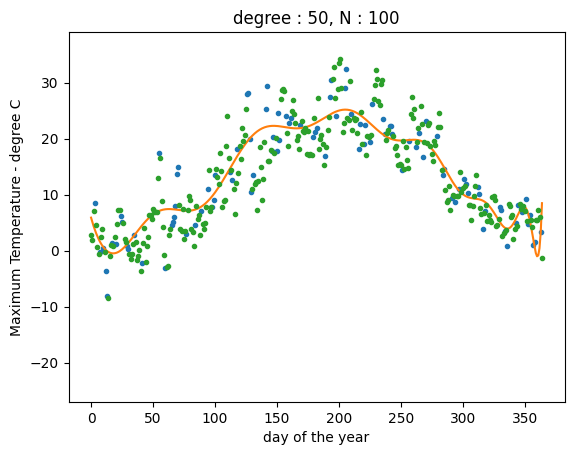

In [8]:

year = 1900
df = load_data(year = year)


np.random.seed(2)
idx = np.random.permutation(df.shape[0])

idx_train = idx[0:100]
idx_test = idx[100:]

data_train = df.iloc[idx_train]
data_test = df.iloc[idx_test]


degree = 50
N_train = 100
x_train = data_train.days.values[:N_train] * 1.0
y_train = data_train.TMAX.values[:N_train]

reg = PolynomialRegression(degree =  degree)
reg.fit(x=x_train,y=y_train)

x_days = np.arange(365)
y_days_pred = reg.pred(x_days)
y_OLS_days_pred = reg.pred(x_days)

x_test = data_test.days.values * 1.0
y_test = data_test.TMAX.values
y_test_pred = reg.pred(x_test)

fig = plt.figure()
plt.plot(x_train,y_train,'.')
plt.plot(x_days,y_days_pred)
plt.plot(x_test,y_test, '.')
plt.ylim([-27,39])
plt.xlabel("day of the year")
plt.ylabel("Maximum Temperature - degree C")
plt.title("degree : %i, N : %i" % (degree,N_train))
plt.show()




## p-norm linear regression

In this task you will implement p-norm linear regression. The difference is in the loss function in which the typical form is mean square error described by the equation:
- equation
P-norm linear regresion however have the form:
- equation

One of the adantages of this approach is that we can control the influence of the outliers for the line fitting.

In the example below we create a toy dataset with 2 random outliers. Play with the p value and see how the line is fitted and how the outliers influence variables.

Another thing is the traning. In linear regression we can easily obrain closed form solution. P-norm regression is difficutl problem in which closed form solution doesnt exist. Therefore numerical method should be used to optimize the loss function.


In order to check weather the analitycal gradient is correctly calculated the test cna be used. You can calculate the gradient analyticly and then check if it is close to the numerical gradient. This is the simple way of debuging



## p-norm linear regression  

In this task, you will implement **p-norm linear regression**. The difference lies in the **loss function**, where the typical form is the **mean squared error (MSE)**:  

$$
L_{\text{MSE}} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$  

However, **p-norm linear regression** generalizes this by using the **p-norm loss function**:  

$$
L_p = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|^p
$$  

where \( p \) is a hyperparameter that controls how the model treats errors.  

In the example below, we create a toy dataset with **two random outliers**. Try adjusting the value of \( p \) and observe how the regression line changes, as well as how the outliers influence the model.  

Unlike standard linear regression, which has a **closed-form solution**, p-norm regression is a difficult optimization problem where a closed-form solution does not exist. Instead, numerical optimization methods must be used to minimize the loss function.  

To verify whether the analytical gradient is correctly computed, we can use a gradient check. The idea is to compute the gradient analytically and then compare it to a numerically estimated gradient. This provides a simple way to debug the implementation:  


$$
\nabla L_p = = \frac{L_p(X, y, w + w_{\text{diff}}, p) - L_p(X, y, w - w_{\text{diff}}, p)}{\epsilon}
$$ 

where $ \epsilon$  is a small value. If the analytical and numerical gradients are close, the implementation is likely correct.  


In [9]:


def generate_dataset(w):
    x = np.linspace(-5,5, 15)
    y = w[0]*x + w[1] + np.random.normal(size=x.shape)

    x = np.append(x, [5, 4.5])
    y = np.append(y, [-4, -4])

    x = x[:,None]
    y = y[:,None]

    X = np.hstack((x, np.ones_like(x)))
    return X, y


Let's implement the loss function, gradient and gradient check for p-norm linear regression.

In [10]:


def get_loss(X,y,w,p):
    assert y.ndim==2, 'Wrong y dim'
    assert w.ndim==2, 'Wrong w dim'
    loss = np.sum(np.power(np.absolute(X@w-y),p)) / X.shape[0]
    return loss

def get_gradient(X,y,w,p):
    grad = p*(np.power(np.absolute((X@w-y)), p-1)*np.sign(X@w-y)).T@X /X.shape[0]
    return grad.T

def get_gradient_finite_differences(X,y,w,p,e):
    grad = np.zeros_like(w)
    for i in range(len(w)):
        w_diff = np.zeros_like(w)
        w_diff[i] += e/2
        grad[i] = (get_loss(X,y,w+w_diff,p) - get_loss(X,y,w-w_diff,p)) / e
    return grad


    



Compare the analytical gradient with the numerical gradient


In [13]:

p = 2.5 
w_real = np.array([[1.75,1.2]]).T
X, y = generate_dataset(w_real)

w_check = np.array([[1.7,1]]).T
grad_analytical = get_gradient(X,y,w_check,p)
grad_numerical = get_gradient_finite_differences(X,y,w_check,p,0.001)
print(np.isclose(grad_analytical, grad_numerical))



[[ True]
 [ True]]


Let's create the dataset and train the model. Model training will be performed using the gradient descent algorithm, which iteratively updates the model's parameters using the following formula:

```math
\theta := \theta - \alpha \nabla J(\theta)

Text(0.5, 1.0, 'Loss over iterations')

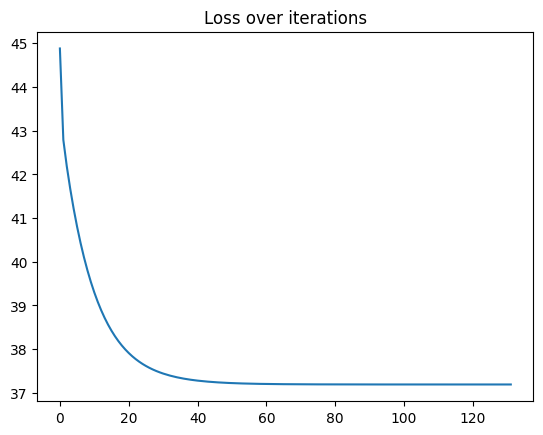

In [14]:

np.random.seed(42)
p = 2.5 

w_solution=np.array([[1],[1]]) # starting solution
lr = 0.01 # learning rate
loss = []
e = 0.000001
for i in range(10000):
    loss.append(get_loss(X,y,w_solution,p))
    grad = get_gradient(X,y,w_solution,p)
    w_solution = w_solution - lr*grad
    if len(loss)>1 and abs(loss[-1]-loss[-2])< e:
            break
plt.figure(2)
plt.plot(loss)
plt.title("Loss over iterations")



Let's visualize the model fit. Pay attention to how the model reacts to outliers for different values of the parameter $p$.


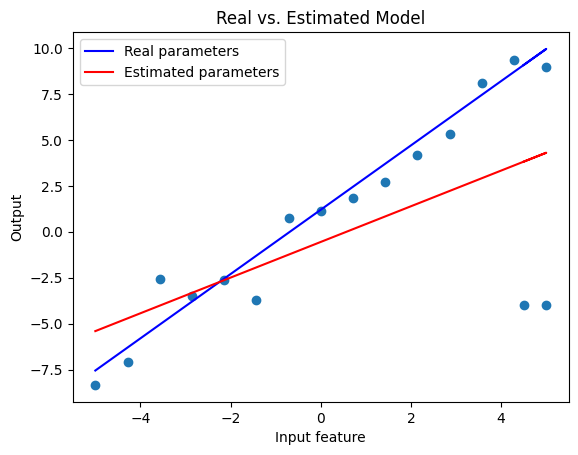

In [15]:

plt.figure(3)
plt.scatter(X[:,0],y)
plt.plot(X[:,0], X@w_real, 'b-', label='Real parameters')
plt.plot(X[:,0],X@w_solution, 'r-', label='Estimated parameters')
plt.title("Real vs. Estimated Model")
plt.xlabel("Input feature")
plt.ylabel("Output")
plt.legend()
plt.show()





